# Multidimensional arrays

IHE, Friday 20 Feb 2017

Theo Olsthoorn, 06-20440256, tolsthoorn@gmail.com

In [1]:
import numpy as np
from scipy.special import exp1 as W # Theis well function
import matplotlib.pyplot as plt
%matplotlib notebook

What is it useful for?

Store multidimensional data, like

+ The head in a numerical network in 2 or 3D
+ time-distacne arrays, combining all times and distances, for instance of a drawdown
+ Multiple measurements

What we'll do

+ The differece between sequences (list, tuples) and numpy arrays (numerical arrays)
+ Show how to generate (with types), and manipulate multidimensional arrays and how to handle them
    .size,
    .shape,
    .reshape(),
    .hstack(),
    .vstack()
+ lists of list versus numerical arrays
+ slicing and indexing in arrays
    - slicing
    - logical indexing (show what's where)
+ Show broadcasting of arrays
+ The difference between an array and a matrix
+ Compute the drawdown versus time and show the drawns for many times and disctances in a single graph
    - a Theis well
    - a well and a mirror well
+ Compute the drawdown on a spatial grid
+ Contour the drawdown
    - line
    - full colors
    - colorbar( with title)
+ Compute the velocities on the grid
+ Show the velocities using quiver
+ Set up a system with a large number of linear equations and solve it.
    + regression
+ logical array indexing using polyline
    + polyline
    + np.spy


## Broadcasting

Broadcasting is automatic completion of differently shaped arrays to allow term by term computations.
This an extremly convinient and powerfull functionality of python's numpy module

In [8]:
x = np.arange(11)
y = np.arange(11)
print(x)
print(y)
print(x.ndim)
print(x.shape)
print(y.ndim)
print(x.shape)


[ 0  1  2  3  4  5  6  7  8  9 10]
[ 0  1  2  3  4  5  6  7  8  9 10]
1
(11,)
1
(11,)


In [6]:
x = x.reshape((1, 11))
print(x)
#x.T.shape
#x.size
print(x.ndim)
print(x.shape)

[[ 0  1  2  3  4  5  6  7  8  9 10]]
2
(1, 11)


In [12]:
x = x.reshape((1, 11))
y = y.reshape((11, 1))
print(x)
print(y)
print(x * y)
#print(y * x)

[[ 0  1  2  3  4  5  6  7  8  9 10]]
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
[[  0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   2   3   4   5   6   7   8   9  10]
 [  0   2   4   6   8  10  12  14  16  18  20]
 [  0   3   6   9  12  15  18  21  24  27  30]
 [  0   4   8  12  16  20  24  28  32  36  40]
 [  0   5  10  15  20  25  30  35  40  45  50]
 [  0   6  12  18  24  30  36  42  48  54  60]
 [  0   7  14  21  28  35  42  49  56  63  70]
 [  0   8  16  24  32  40  48  56  64  72  80]
 [  0   9  18  27  36  45  54  63  72  81  90]
 [  0  10  20  30  40  50  60  70  80  90 100]]


In [15]:
xy = x * y
print(xy)
print(xy.shape)
print(xy[2])
print(xy[2].shape)


[[  0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   2   3   4   5   6   7   8   9  10]
 [  0   2   4   6   8  10  12  14  16  18  20]
 [  0   3   6   9  12  15  18  21  24  27  30]
 [  0   4   8  12  16  20  24  28  32  36  40]
 [  0   5  10  15  20  25  30  35  40  45  50]
 [  0   6  12  18  24  30  36  42  48  54  60]
 [  0   7  14  21  28  35  42  49  56  63  70]
 [  0   8  16  24  32  40  48  56  64  72  80]
 [  0   9  18  27  36  45  54  63  72  81  90]
 [  0  10  20  30  40  50  60  70  80  90 100]]
(11, 11)
[ 0  2  4  6  8 10 12 14 16 18 20]
(11,)


## Compute function of t and r for all combinations simultaneously

Let's compute the drawdown due to a transient well for may times and distances simultaneously and show the drawdown for many times as s function of r and for many r as a function of time.

$$ s = \frac {Q_0} {4 \pi kD} W(u), \,\,\,\, u = \frac {r^2 S} {4 kD t} $$

<IPython.core.display.Javascript object>


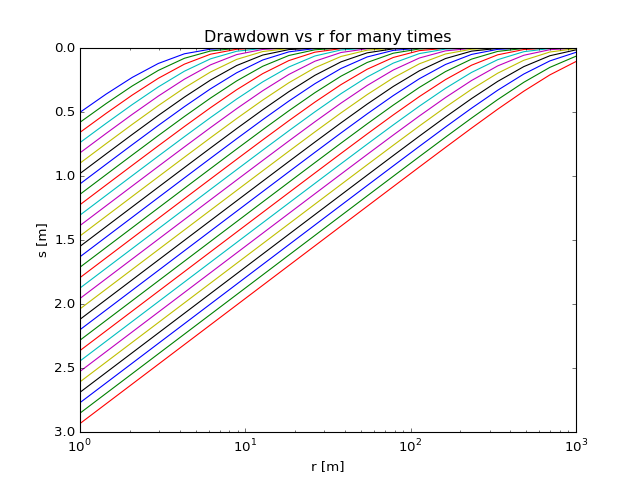

<IPython.core.display.Javascript object>


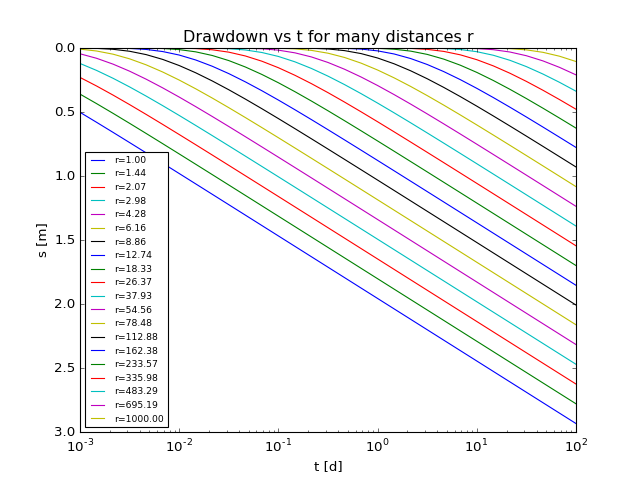

In [33]:
Q = 2400 # m3/d
S = 0.2
kD = 900 # m2/d

Nt = 31 # number of times
Nr = 20 # number of distances

times = np.logspace(-3, 2, Nt)
distances = np.logspace(0, 3, Nr)
u = distances.reshape((1,Nr)) ** 2 * S / (4 * kD * times.reshape((Nt,1)))

s = Q / (4 * np.pi * kD) * W(u)

fig1, ax1 = plt.subplots()
ax1.set_xlabel('r [m]')
ax1.set_ylabel('s [m]')
ax1.set_xscale('log')
ax1.set_title('Drawdown vs r for many times')

#for it, t in enumerate(times):
#    ax1.plot(distances, s[it,:])
for it, t in enumerate(times):
    ax1.plot(distances, s[it,:])

ax1.invert_yaxis()


fig2, ax2 = plt.subplots()
ax2.set_xlabel('t [d]')
ax2.set_ylabel('s [m]')
ax2.set_xscale('log')
ax2.set_title('Drawdown vs t for many distances r')
for ir, r in enumerate(distances):
    ax2.plot(times, s[:,ir], label='r={:.2f}'.format(r))
ax2.invert_yaxis()
ax2.legend(loc='best', fontsize='x-small')
plt.show()

In [ ]:
Q = 2400 # m3/d
S = 0.2
kD = 900 # m2/d

Nt = 30
Nr = 20
times = np.logspace(-3, 2, Nt)
distances = np.logspace(0, 3, Nr)

u = distances.reshape((1,Nr)) ** 2 * S / (4 * kD * times.reshape((Nt,1)))

s = Q / (4 * np.pi * kD) * W(u)

print(u.shape)

fig1, ax1 = plt.subplots()
ax1.set_xlabel('r [m]')
ax1.set_ylabel('s [m]')
ax1.set_xscale('log')
ax1.set_title('Drawdown vs r for many times')
for it, t in enumerate(times):
    ax1.plot(distances, s[it,:])
ax1.invert_yaxis()
plt.show()

fig2, ax2 = plt.subplots()
ax2.set_xlabel('t [d]')
ax2.set_ylabel('s [m]')
ax2.set_xscale('log')
ax2.set_title('Drawdown vs t for many distances r')
for ir, r in enumerate(distances):
    ax2.plot(times, s[:,ir])
ax2.invert_yaxis()
plt.show()


## Contouring your data

Compute the distance from an arbitrary point x, y to the well at x0, y0,
then extend x, y over a full grid and compute the drawdown in every point.
Finally contour the drawdowns.

We use the same well function and aquifer data as before.

In [66]:
# aquifer
kD = 900 # m2/d
S = 0.15

# times
t = 1.2 # d

# coordinates
x = np.linspace(-500, 500, 101)
y = np.linspace(-500, 500, 101)
Nx = len(x)
Ny = len(y)
X = np.ones((len(y), 1)) * x[np.newaxis, :]
Y = y[:, np.newaxis] * np.ones((1, len(x)))

# wells
xw = [-100., 100.]
yw = [   0., 0.]
rw = [ 0.25, 0.25]
Qw  = [1200., -1200.] # m3/d


s = np.zeros_like(X)
qr = np.zeros_like(X)
qx = np.zeros_like(X)
qy = np.zeros_like(X)

for x0, y0, r0, Q0 in zip(xw, yw, rw, Qw):  
    r = np.sqrt((X - x0)**2 + (Y - y0)**2)
    r[r==0] = r0
    u = r**2 * S / (4 * kD * t)
    s += Q0 / (4 * np.pi * kD) * W(u)
    q  = Q0 * np.exp(-u) / (2 * np.pi * r)
    qr += q 
    qx += q * (x0 - X)/r
    qy += q * (y0 - Y)/r

<IPython.core.display.Javascript object>


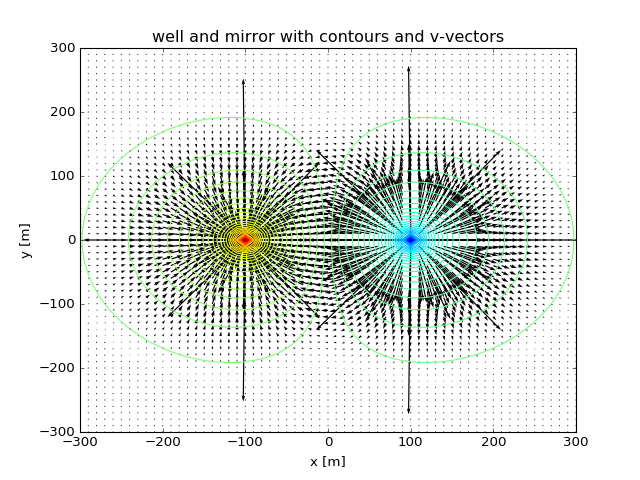

In [67]:
xlim=(-300, 300)
ylim=(-300, 300)

fig, ax = plt.subplots()

ax.contour(x, y, s, np.linspace(np.min(s), np.max(s), 100))
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('well and mirror with contours and v-vectors')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.quiver(X, Y, qx, qy)
plt.show()

#### full colors

<IPython.core.display.Javascript object>


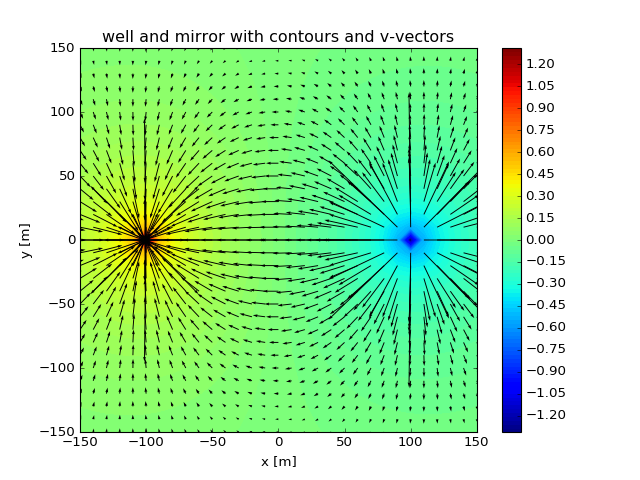

In [36]:
xlim=(-150, 150)
ylim=(-150, 150)

fig, ax = plt.subplots()

cs = ax.contourf(x, y, s, np.linspace(np.min(s), np.max(s), 100))
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('well and mirror with contours and v-vectors')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.quiver(X, Y, qx, qy)
fig.colorbar(cs, ticks=np.linspace(-1.5, 1.5, 21))
plt.show()

### with plt.matshow()

<IPython.core.display.Javascript object>


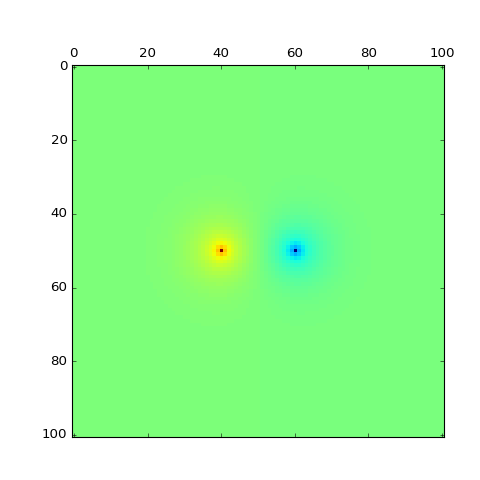

In [37]:
plt.matshow(s)
plt.show()

### Run a 3D finite difference groundwater model and show results

In [38]:
mymodules = './modules'
import sys
if not mymodules in sys.path:
    sys.path.insert(1, mymodules)

import fdm
import mfgrid

def inpoly(...)


<IPython.core.display.Javascript object>


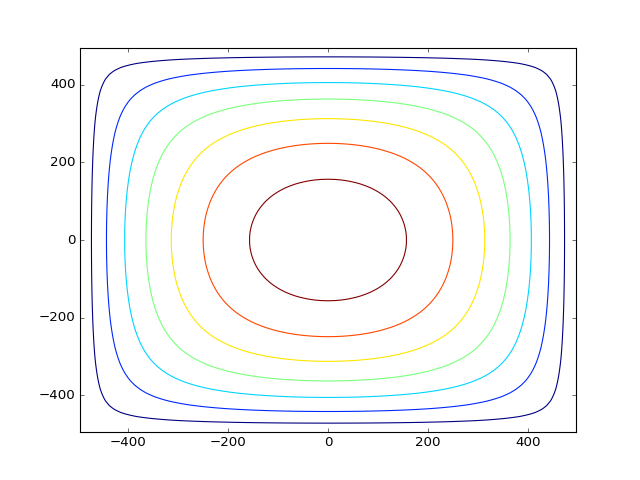

In [39]:
### Logical array indexing, data within a polyline (matplotlib path)
xGr = np.linspace(-500, 500, 101)
yGr = np.linspace(-500, 500, 101)
zGr = np.array([0, -10, -100])

gr = mfgrid.Grid(xGr, yGr, zGr)

fig, ax = plt.subplots()

#gr.plot_grid()

rch = 0.001 # m/d

k = gr.const(10.)
FQ = gr.const(0);  FQ[:,:,0] = rch * gr.Area
FH = gr.const(0.)
IBOUND = gr.const(1)
IBOUND[[0,-1], :, :] = -1
IBOUND[:, [0,-1], :] = -1

Out= fdm.fdm3(gr, (k, k, k), FQ, FH, IBOUND)

ax.contour(gr.xm, gr.ym, Out.Phi[:, :, 0], level=30)
plt.show()


In [40]:
wells = np.array([[100, 175, -1200.],
                  [-205, 33, -800.],
                  [-80, 165, -600.]])

ixw = gr.ix(wells[:,0])
iyw = gr.iy(wells[:,1])
Qw  = wells[:,-1]

for ix, iy, Q in zip(ixw, iyw, Qw):
    FQ[iy, ix, -1] = Q 

<IPython.core.display.Javascript object>


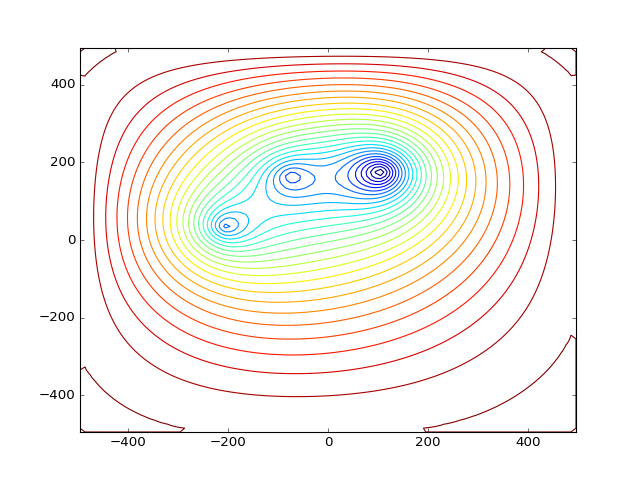

In [41]:
fig, ax = plt.subplots()

Out= fdm.fdm3(gr, (k, k, k), FQ, FH, IBOUND)

ax.contour(gr.xm, gr.ym, Out.Phi[:, :, 0], 30)
plt.show()


<IPython.core.display.Javascript object>


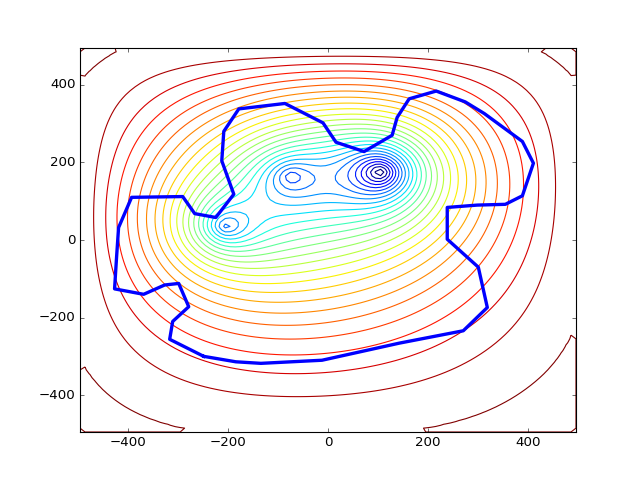

In [42]:
import coords
crds = coords.coords * 2
crds[:,0] -=600
crds[:,1] -= 400
crds = np.vstack((crds, crds[0]))


fig, ax = plt.subplots()
ax.contour(gr.xm, gr.ym, Out.Phi[:, :, 0], 30)
ax.plot(crds[:,0], crds[:,1], lw=3)
plt.show()




In [43]:
island = gr.inpoly(crds)

In [ ]:
fig, ax = plt.subplots()
ax.spy(island)

In [44]:
ibnd = IBOUND[:,:, 0]
ibnd[~island] = -1
IBOUND[:,:,0] = ibnd
IBOUND[:,:,1] = ibnd

<IPython.core.display.Javascript object>


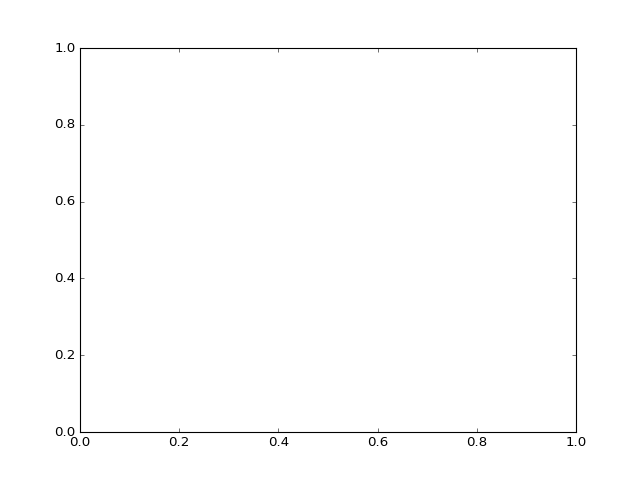

In [75]:
Out= fdm.fdm3(gr, (k, k, k), FQ, FH, IBOUND)

fig, ax = plt.subplots()

ax.contour(gr.xm, gr.ym, Out.Phi[:, :, 0], 30)
ax.plot(crds[:,0], crds[:,1], 'b', lw=3)
plt.show()


In [ ]:
print('total across boundaries: ', np.sum(Out.Q[IBOUND==-1]))
print('total recharge:          ', np.sum(Out.Q[np.logical_and(FQ<0, IBOUND>0)]))
print('total wells:             ', np.sum(Out.Q[IBOUND== 1]))

# Using np.meshgrid to generate full n-dimensional arrays of the grid coordinates

You can get help on meshgrid as follows

In [76]:
np.meshgrid?

This is what meshgrid makes of it:  (1, 100, 1) (100, 1, 1) (1, 1, 9)
This is exactly the same:           (1, 100, 1) (100, 1, 1) (1, 1, 9)
This is the shape of the generated 3D array:  (100, 100, 9)


<IPython.core.display.Javascript object>


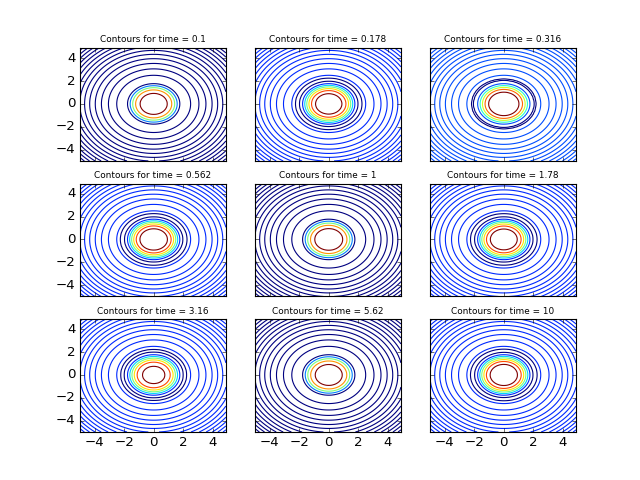

In [123]:
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
times = np.logspace(-1, 1, 9)
xx, yy, tt = np.meshgrid(x, y, times, sparse=True)

# here you see what mesh grid does
print("This is what meshgrid makes of it: ",xx.shape, yy.shape, tt.shape)

# meshgrid only reshapes the vectors like so:
x = x.reshape(1, len(x), 1)
y = y.reshape(len(y), 1, 1)
times = times.reshape(1, 1, len(times))
print("This is exactly the same:          ",x.shape, y.shape, times.shape)

# by reshaping the vectors, they can be used for broadcasting
# (generating full flexged arrays by multiplying, e.g.:
print#  x * y * times = a )

# restore x, y and times, otherwize plotting complains about dimensions passed
x = x.ravel()
y = y.ravel()
times = times.ravel()

# Let's continue with the exmemple:
# Generate a 3D array to contour using xx, yy and tt !
# Realize that we are broadcasting in 3 dimensions:
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2) * np.exp(-tt)
print("This is the shape of the generated 3D array: ", z.shape)

# contourllevels (because of sine values are between -1 and+1)
levels = np.linspace(-1, 1, 25)

# Let's make a contour plot of each layer. Notice that each layer holds
# all x,y grid combination for a given time times[it]

# first generate a grid or 3x3 (=9) axes. We have 9 time values
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

axs = axs.ravel() # axs is a 3x3 array of axes, flatten it, so I can index sequentially

for it, t in enumerate(times):
    axs[it].set_title("Contours for time = {:.3g}".format(t), fontsize=8)
    axs[it].contour(x,y,z[:,:,it], level=levels) # contour layer it which is whole grid for t=t[it]
plt.show()

In [119]:
z[:,:,0].shape

(100, 100)